# 💊 Drug Detection

## Preprocessing

* Dropping Duplicates, infinities and NaNs

* Splitting the Dataset in 8:2 for Train Set and Test Set

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv("Dataset/final/dataset.csv")

df.drop_duplicates(inplace=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

x = df.drop(columns=["smiles", "Is Drug"])
y = df["Is Drug"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)

print(f"✅ Train set shape:       {x_train.shape}, Labels: {y_train.shape}")
print(f"✅ Test shape:   {x_test.shape}, Labels: {y_test.shape}")

✅ Train set shape:       (49707, 2991), Labels: (49707,)
✅ Test shape:   (12427, 2991), Labels: (12427,)


#### Class Distribution

🔢 Full Dataset — Total: 62134
  Class 0: 56237 (90.51%)
  Class 1: 5897 (9.49%)

🔢 Train Set — Total: 49707
  Class 0: 44989 (90.51%)
  Class 1: 4718 (9.49%)

🔢 Test Set — Total: 12427
  Class 0: 11248 (90.51%)
  Class 1: 1179 (9.49%)



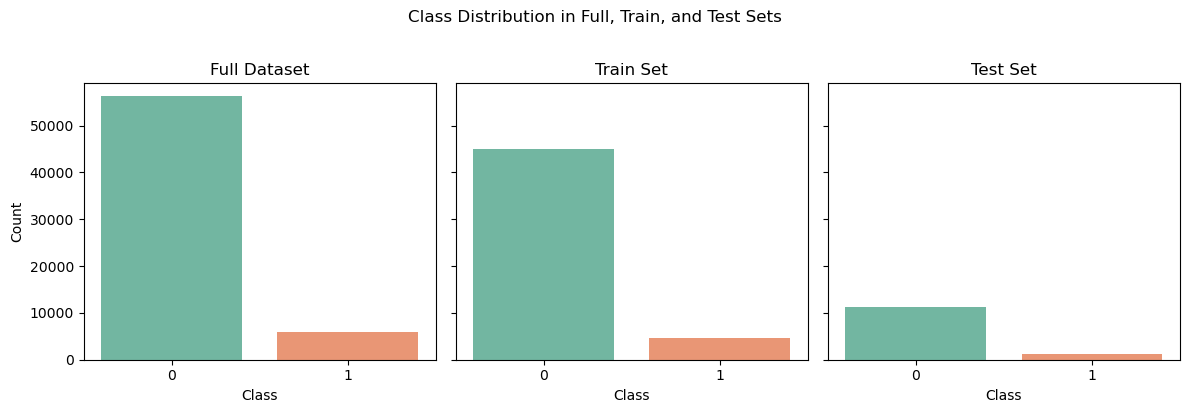

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

train_df = x_train.copy()
train_df["Is Drug"] = y_train.values

test_df = x_test.copy()
test_df["Is Drug"] = y_test.values

df = pd.concat([train_df, test_df])

def print_class_ratios(name, series):
    value_counts = series.value_counts()
    total = len(series)
    print(f"🔢 {name} — Total: {total}")
    for label in sorted(value_counts.index):
        count = value_counts[label]
        pct = 100 * count / total
        print(f"  Class {label}: {count} ({pct:.2f}%)")
    print()

print_class_ratios("Full Dataset", df["Is Drug"])
print_class_ratios("Train Set", train_df["Is Drug"])
print_class_ratios("Test Set", test_df["Is Drug"])

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

sns.countplot(data=df, x="Is Drug", hue="Is Drug", palette="Set2", legend=False, ax=axes[0])
axes[0].set_title("Full Dataset")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

sns.countplot(data=train_df, x="Is Drug", hue="Is Drug", palette="Set2", legend=False, ax=axes[1])
axes[1].set_title("Train Set")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("")

sns.countplot(data=test_df, x="Is Drug", hue="Is Drug", palette="Set2", legend=False, ax=axes[2])
axes[2].set_title("Test Set")
axes[2].set_xlabel("Class")
axes[2].set_ylabel("")

plt.suptitle("Class Distribution in Full, Train, and Test Sets", y=1.02)
plt.tight_layout()
plt.show()


### 🔁 Cross-Validation

We perform 5-fold cross-validation using only the training data to estimate the model's generalization performance without data leakage. Roc-Auc is used as the scoring metric.

The pipeline is as follows

* Feature reduction using variance thresold

* Standardization using Standard Scaler

* 5-fold Cross Validatin using Logistic Regression on the Train Set

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    accuracy_score, recall_score, confusion_matrix, roc_auc_score
)
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
import numpy as np

vt = VarianceThreshold(threshold=0.01)
scaler = StandardScaler()

x_train_vt = vt.fit_transform(x_train)
x_train_scaled = scaler.fit_transform(x_train_vt)

cv_model = LogisticRegressionCV(
    Cs=[0.01, 0.1, 1, 10],
    penalty='elasticnet',
    solver='saga',
    l1_ratios=[0.5],
    class_weight='balanced',
    scoring='roc_auc',
    max_iter=20000,
    cv=5,
    n_jobs=-1,
    verbose=3,
    random_state=42
)
cv_model.fit(x_train_scaled, y_train)

best_C = cv_model.C_[0]
best_l1 = cv_model.l1_ratio_[0]

print(f"✅ Best C: {best_C}")
print(f"✅ Best l1_ratio: {best_l1}")

pipeline = Pipeline([
    ('vt', VarianceThreshold(threshold=0.01)),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        C=best_C,
        penalty='elasticnet',
        solver='saga',
        l1_ratio=best_l1,
        class_weight='balanced',
        max_iter=20000,
        random_state=42
    ))
])

y_scores_cv = cross_val_predict(
    pipeline, x_train, y_train,
    method='predict_proba',
    cv=5,
    n_jobs=-1
)[:, 1]

y_pred_cv = (y_scores_cv >= 0.5).astype(int)
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_cv).ravel()

metrics_cv = {
    "Best C": best_C,
    "Best l1_ratio": best_l1,
    "Threshold": 0.5,
    "Accuracy": accuracy_score(y_train, y_pred_cv),
    "Sensitivity (Recall)": recall_score(y_train, y_pred_cv),
    "Specificity": tn / (tn + fp),
    "ROC-AUC": roc_auc_score(y_train, y_scores_cv)
}

print("\n✅ Cross-validated Training Performance (Final Model):")
for k, v in metrics_cv.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.


convergence after 4025 epochs took 1671 seconds
convergence after 4170 epochs took 1780 seconds
convergence after 4065 epochs took 1814 seconds
convergence after 4156 epochs took 1848 seconds
convergence after 454 epochs took 191 seconds
convergence after 4244 epochs took 1888 seconds
convergence after 59 epochs took 27 seconds
convergence after 7 epochs took 4 seconds
convergence after 460 epochs took 200 seconds
convergence after 60 epochs took 26 seconds
convergence after 6 epochs took 3 seconds


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 33.5min remaining: 50.2min


convergence after 468 epochs took 200 seconds
convergence after 62 epochs took 26 seconds
convergence after 6 epochs took 3 seconds
convergence after 478 epochs took 213 seconds
convergence after 443 epochs took 195 seconds
convergence after 61 epochs took 27 seconds
convergence after 7 epochs took 3 seconds
convergence after 58 epochs took 26 seconds
convergence after 5 epochs took 2 seconds


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 35.2min finished


convergence after 459 epochs took 246 seconds
✅ Best C: 10.0
✅ Best l1_ratio: 0.5

✅ Cross-validated Training Performance (Final Model):
Best C: 10.0000
Best l1_ratio: 0.5000
Threshold: 0.5000
Accuracy: 0.8958
Sensitivity (Recall): 0.9267
Specificity: 0.8926
ROC-AUC: 0.9652


### Threshold Optimization

In [ ]:
import numpy as np
from sklearn.metrics import (
    f1_score, matthews_corrcoef, accuracy_score,
    recall_score, precision_score, confusion_matrix,
    roc_auc_score
)

thresholds = np.linspace(0.0, 1.0, 201)

best_metrics = {
    "Threshold": 0.0,
    "F1 Score": 0.0,
    "MCC": -1.0,
    "Sensitivity (Recall)": 0.0,
    "Specificity": 0.0,
    "Precision": 0.0,
    "Accuracy": 0.0,
    "ROC-AUC": 0.0
}

for t in thresholds:
    preds = (y_scores_cv >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_train, preds).ravel()

    f1 = f1_score(y_train, preds, zero_division=0)
    mcc = matthews_corrcoef(y_train, preds)
    acc = accuracy_score(y_train, preds)
    se = recall_score(y_train, preds)
    sp = tn / (tn + fp) if (tn + fp) > 0 else 0
    prec = precision_score(y_train, preds, zero_division=0)
    auc = roc_auc_score(y_train, y_scores_cv)

    if mcc > best_metrics["MCC"]:
        best_metrics.update({
            "Threshold": t,
            "F1 Score": f1,
            "MCC": mcc,
            "Sensitivity (Recall)": se,
            "Specificity": sp,
            "Precision": prec,
            "Accuracy": acc,
            "ROC-AUC": auc
        })

print("🔍 Optimal Threshold Based on MCC:")
for k, v in best_metrics.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")


🔍 Optimal Threshold Based on MCC:
Threshold: 0.7800
F1 Score: 0.7209
MCC: 0.6917
Sensitivity (Recall): 0.7825
Specificity: 0.9593
Precision: 0.6682
Accuracy: 0.9425
ROC-AUC: 0.9652


#### Hyperparameter Settings of the Logistic Regression Model

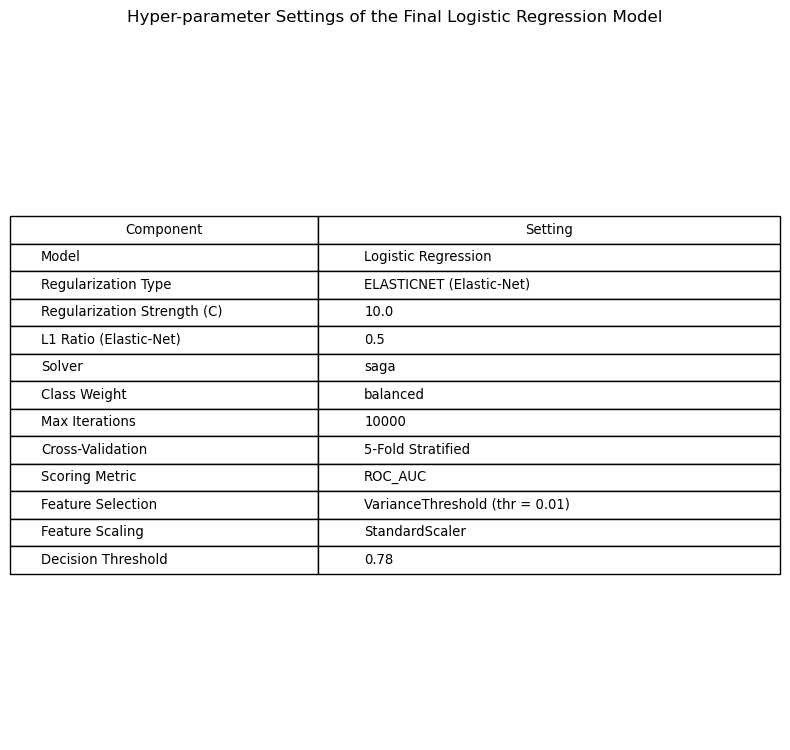

In [ ]:
import matplotlib.pyplot as plt

vt           = pipeline.named_steps['vt']
scaler       = pipeline.named_steps['scaler']
final_model  = pipeline.named_steps['clf']

penalty        = final_model.penalty.upper()
C_value        = final_model.C
solver         = final_model.solver
l1_ratio       = getattr(final_model, "l1_ratio", None)
class_weight   = final_model.class_weight
max_iter       = final_model.max_iter
cv_strategy    = "5-Fold Stratified"
scoring_metric = "ROC_AUC"
vt_thresh      = vt.threshold
scaler_type    = scaler.__class__.__name__

optimal_threshold = best_metrics["Threshold"]

labels = [
    "Model",
    "Regularization Type",
    "Regularization Strength (C)",
    "L1 Ratio (Elastic-Net)",
    "Solver",
    "Class Weight",
    "Max Iterations",
    "Cross-Validation",
    "Scoring Metric",
    "Feature Selection",
    "Feature Scaling",
    "Decision Threshold"
]

values = [
    "Logistic Regression",
    f"{penalty} (Elastic-Net)",
    f"{C_value}",
    f"{l1_ratio}",
    solver,
    str(class_weight),
    str(max_iter),
    cv_strategy,
    scoring_metric,
    f"VarianceThreshold (thr = {vt_thresh})",
    scaler_type,
    f"{optimal_threshold:.2f}"
]

fig, ax = plt.subplots(figsize=(8, len(labels) * 0.55 + 1))
ax.axis('off')

table = plt.table(
    cellText=[[l, v] for l, v in zip(labels, values)],
    colLabels=["Component", "Setting"],
    loc="center",
    cellLoc="left",
    colWidths=[0.4, 0.6]
)

table.auto_set_font_size(False)
table.set_fontsize(9.5)
table.scale(1, 1.4)

plt.title("Hyper-parameter Settings of the Final Logistic Regression Model",
          fontsize=12, pad=20)
plt.tight_layout()
plt.show()


#### 5-Fold Cross-Validation Performance (Training Set)

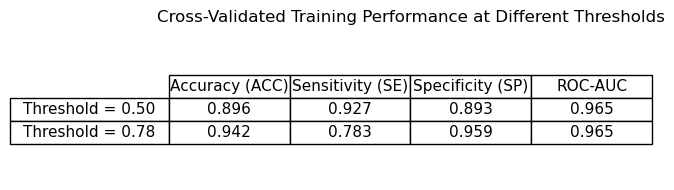

In [ ]:
import matplotlib.pyplot as plt

metrics_summary = {
    "Accuracy (ACC)": [
        metrics_cv["Accuracy"],
        best_metrics["Accuracy"]
    ],
    "Sensitivity (SE)": [
        metrics_cv["Sensitivity (Recall)"],
        best_metrics["Sensitivity (Recall)"]
    ],
    "Specificity (SP)": [
        metrics_cv["Specificity"],
        best_metrics["Specificity"]
    ],
    "ROC-AUC": [
        metrics_cv["ROC-AUC"],
        best_metrics["ROC-AUC"]
    ]
}

column_labels = list(metrics_summary.keys())
row_labels = [f"Threshold = 0.50", f"Threshold = {best_metrics['Threshold']:.2f}"]

row_values = [
    [f"{v:.3f}" for v in values]
    for values in zip(*metrics_summary.values())
]

fig, ax = plt.subplots(figsize=(7, 2))
ax.axis('off')

table = ax.table(
    cellText=row_values,
    rowLabels=row_labels,
    colLabels=column_labels,
    loc='center',
    cellLoc='center',
    rowLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.5)

plt.title("Cross-Validated Training Performance at Different Thresholds", fontsize=12, pad=12)
plt.tight_layout()
plt.show()


#### 5-Fold CV Confusion Matrix

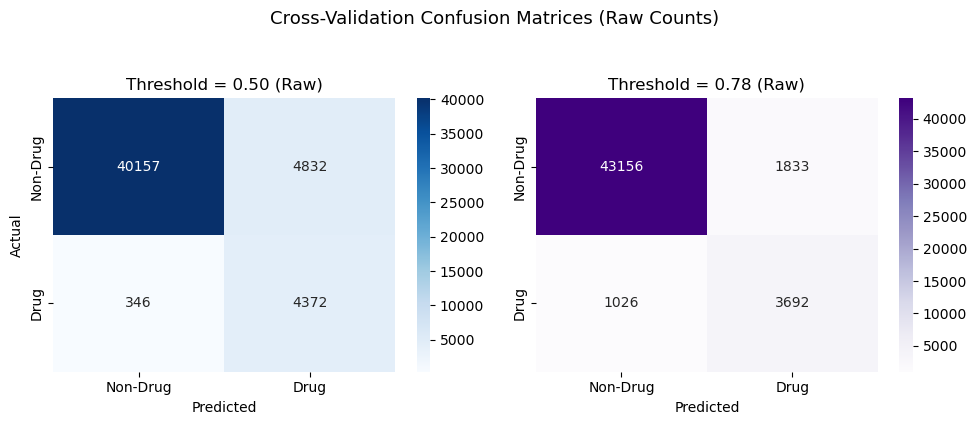

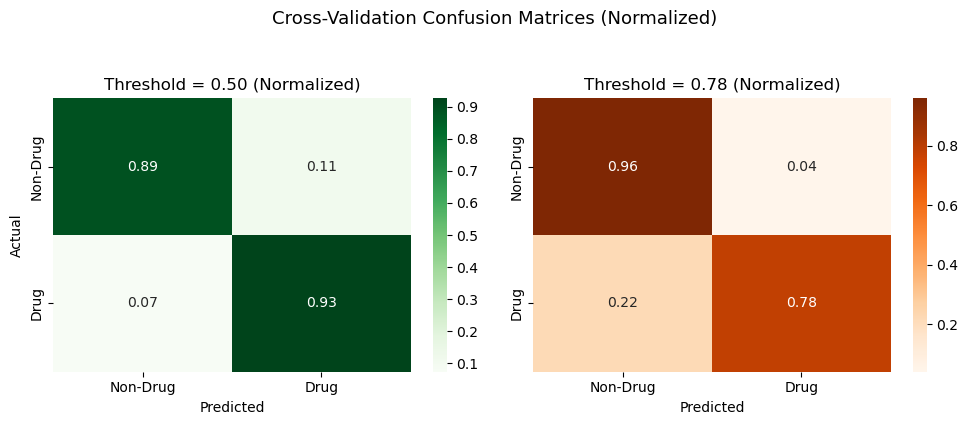

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred_best = (y_scores_cv >= best_metrics["Threshold"]).astype(int)

cm_50_raw = confusion_matrix(y_train, y_pred_cv)
cm_50_norm = cm_50_raw.astype('float') / cm_50_raw.sum(axis=1)[:, np.newaxis]

cm_best_raw = confusion_matrix(y_train, y_pred_best)
cm_best_norm = cm_best_raw.astype('float') / cm_best_raw.sum(axis=1)[:, np.newaxis]

labels = ['Non-Drug', 'Drug']

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(cm_50_raw, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title("Threshold = 0.50 (Raw)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_best_raw, annot=True, fmt='d', cmap='Purples',
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title(f"Threshold = {best_metrics['Threshold']:.2f} (Raw)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("")

plt.suptitle("Cross-Validation Confusion Matrices (Raw Counts)", fontsize=13, y=1.05)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(cm_50_norm, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title("Threshold = 0.50 (Normalized)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_best_norm, annot=True, fmt='.2f', cmap='Oranges',
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title(f"Threshold = {best_metrics['Threshold']:.2f} (Normalized)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("")

plt.suptitle("Cross-Validation Confusion Matrices (Normalized)", fontsize=13, y=1.05)
plt.tight_layout()
plt.show()


## Evaluating the model on Test Set

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix, matthews_corrcoef

pipeline.fit(x_train, y_train)

y_test_pred = pipeline.predict(x_test)
y_test_probs = pipeline.predict_proba(x_test)[:, 1]

tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

acc = accuracy_score(y_test, y_test_pred)
se = recall_score(y_test, y_test_pred)
sp = tn / (tn + fp) if (tn + fp) != 0 else 0.0
mcc = matthews_corrcoef(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_probs)

metrics_test = {
    "Accuracy": acc,
    "Sensitivity (Recall)": se,
    "Specificity": sp,
    "MCC": mcc,
    "ROC-AUC": auc
}


#### Performance with Optimized Thresold

In [ ]:
from sklearn.metrics import (
    accuracy_score, recall_score, confusion_matrix,
    matthews_corrcoef, precision_score, roc_auc_score
)

opt_thresh = best_metrics["Threshold"]

y_pred_opt = (y_test_probs >= opt_thresh).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_opt).ravel()

metrics_test_opt = {
    "Threshold": opt_thresh,
    "Accuracy": accuracy_score(y_test, y_pred_opt),
    "Sensitivity (Recall)": recall_score(y_test, y_pred_opt),
    "Specificity": tn / (tn + fp),
    "Precision": precision_score(y_test, y_pred_opt),
    "MCC": matthews_corrcoef(y_test, y_pred_opt),
    "ROC-AUC": roc_auc_score(y_test, y_test_probs)
}


#### Test Set Performance Metrics

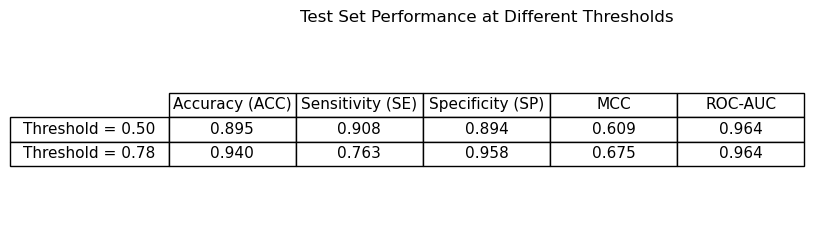

In [ ]:
import matplotlib.pyplot as plt

metrics_summary = {
    "Accuracy (ACC)": [
        metrics_test["Accuracy"],
        metrics_test_opt["Accuracy"]
    ],
    "Sensitivity (SE)": [
        metrics_test["Sensitivity (Recall)"],
        metrics_test_opt["Sensitivity (Recall)"]
    ],
    "Specificity (SP)": [
        metrics_test["Specificity"],
        metrics_test_opt["Specificity"]
    ],
    "MCC": [
        metrics_test["MCC"],
        metrics_test_opt["MCC"]
    ],
    "ROC-AUC": [
        metrics_test["ROC-AUC"],
        metrics_test_opt["ROC-AUC"]
    ]
}

column_labels = list(metrics_summary.keys())
row_labels = [
    "Threshold = 0.50",
    f"Threshold = {metrics_test_opt['Threshold']:.2f}"
]

row_values = [
    [f"{v:.3f}" for v in values]
    for values in zip(*metrics_summary.values())
]

fig, ax = plt.subplots(figsize=(8.5, 2.4))
ax.axis('off')

table = ax.table(
    cellText=row_values,
    rowLabels=row_labels,
    colLabels=column_labels,
    loc='center',
    cellLoc='center',
    rowLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.5)

plt.title("Test Set Performance at Different Thresholds", fontsize=12, pad=12)
plt.tight_layout()
plt.show()


#### Test Set Confusion Matrix (Normalized)

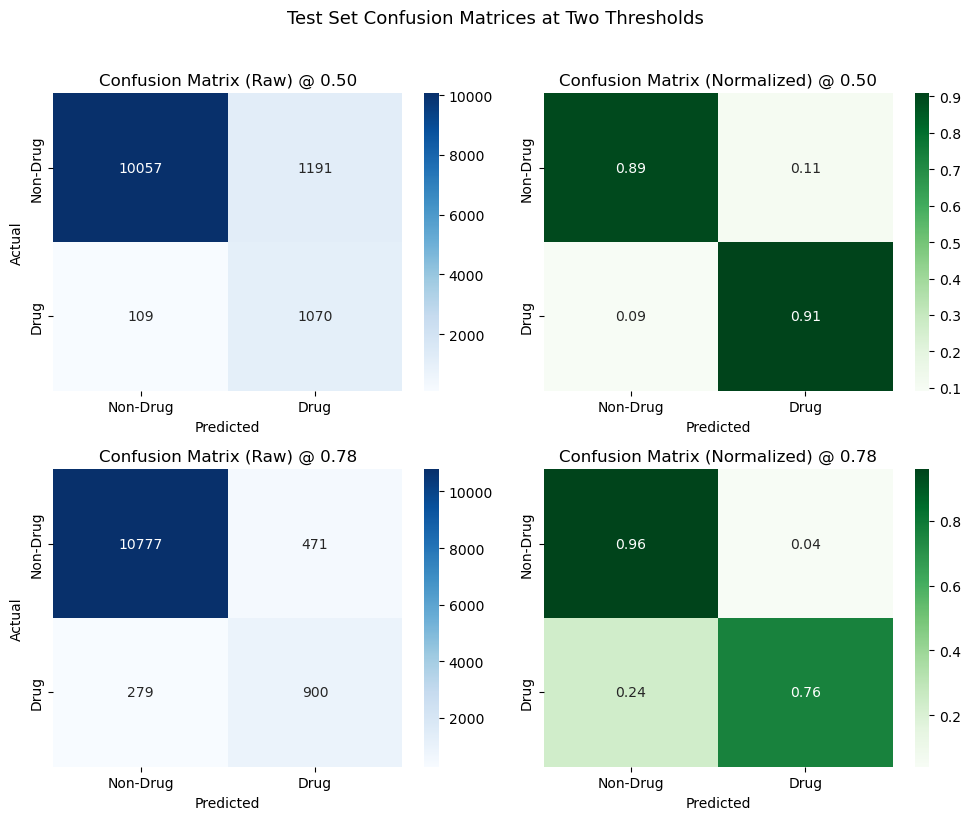

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

thresh_default = 0.5
thresh_opt = metrics_test_opt["Threshold"]

y_pred_05 = (y_test_probs >= thresh_default).astype(int)
y_pred_opt = (y_test_probs >= thresh_opt).astype(int)

cm_raw_05 = confusion_matrix(y_test, y_pred_05)
cm_raw_opt = confusion_matrix(y_test, y_pred_opt)

cm_norm_05 = cm_raw_05.astype("float") / cm_raw_05.sum(axis=1)[:, np.newaxis]
cm_norm_opt = cm_raw_opt.astype("float") / cm_raw_opt.sum(axis=1)[:, np.newaxis]

labels = ["Non-Drug", "Drug"]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

sns.heatmap(cm_raw_05, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[0, 0])
axes[0, 0].set_title("Confusion Matrix (Raw) @ 0.50")
axes[0, 0].set_xlabel("Predicted")
axes[0, 0].set_ylabel("Actual")

sns.heatmap(cm_norm_05, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=labels, yticklabels=labels, ax=axes[0, 1])
axes[0, 1].set_title("Confusion Matrix (Normalized) @ 0.50")
axes[0, 1].set_xlabel("Predicted")
axes[0, 1].set_ylabel("")

sns.heatmap(cm_raw_opt, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[1, 0])
axes[1, 0].set_title(f"Confusion Matrix (Raw) @ {thresh_opt:.2f}")
axes[1, 0].set_xlabel("Predicted")
axes[1, 0].set_ylabel("Actual")

sns.heatmap(cm_norm_opt, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=labels, yticklabels=labels, ax=axes[1, 1])
axes[1, 1].set_title(f"Confusion Matrix (Normalized) @ {thresh_opt:.2f}")
axes[1, 1].set_xlabel("Predicted")
axes[1, 1].set_ylabel("")

plt.suptitle("Test Set Confusion Matrices at Two Thresholds", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()


### 💾 Exporting Model and Preprocessing Objects

To ensure consistent inference, we save all key components of the training pipeline:

These objects are exported using `joblib` and can later be reloaded to preprocess new SMILES-derived features and make predictions without retraining.


In [ ]:
import joblib

model_bundle = {
    "pipeline": pipeline,
    "threshold": best_metrics["Threshold"]
}

joblib.dump(model_bundle, 'Model/druglikeness_logreg_bundle.pkl')

print("✅ Model bundle (pipeline + threshold) saved to 'Model/druglikeness_logreg_bundle.pkl'")


✅ Model bundle (pipeline + threshold) saved to 'Model/druglikeness_logreg_bundle.pkl'
